# Project 2: Planets around TRAPPIST-1 

## Goal and Objectives

Simulate the movements of planets near the star TRAPPIST-1

1. Simulate movement of the 6 closest planets (b, c, d, e, f, g) for 1000 earth days
2. From which planets can an observer see the most other planets so close that one could resolve features of size 1000 km by naked eye?

The Space Tourism Bureau suggests TRAPPIST-1e (see poster below). Are they right?

![Planet Hop from TRAPPIST-1e. Voted best "Hab Zone" vacation within 12 parsecs of Earth](https://exoplanets.nasa.gov/system/resources/detail_files/2159_posternormalsize.jpg)
(From [NASA Exoplanet Exploration: Galleries: TRAPPIST-1](https://exoplanets.nasa.gov/resources/2159/?linkId=34784370).)

## Data 

Use pandas during development. Replace with something simpler for project.

In [1]:
import pandas as pd

In [2]:
system = pd.read_hdf("../data/trappist_bodies.hdf5", "LOCAL_UNITS")
system.sort_values('name', inplace=True)

In [3]:
system

,name,mass,period,radius,semi-major,eccentricity
0,b,0.000032,1.510871,1.086,11.11,0.081
1,c,0.000052,2.421823,1.056,15.21,0.083
2,d,0.000015,4.049610,0.772,21.44,0.070
3,e,0.000023,6.099615,0.918,28.17,0.085
4,f,0.000025,9.206690,1.045,37.10,0.063
5,g,0.000050,12.352940,1.127,45.10,0.061
6,h,NaN,20.000000,0.755,63.00,NaN
7,star,1.000000,NaN,0.117,NaN,NaN


In [4]:
planets = system[system['name'] != "star"]
planets = planets.dropna()
star = system[system['name'] == "star"]
M_star = star['mass'].iloc[0]  

assert M_star == 1.0

In [5]:
system_AU = pd.read_hdf("../data/trappist_bodies.hdf5", "SOLAR_UNITS")
M_star_in_solar_mass = system_AU[system_AU['name'] == "star"]['mass'].item()
print(M_star_in_solar_mass)

0.0802


In [6]:
system_AU

,name,mass,period,radius,semi-major,eccentricity
0,b,0.000003,0.004137,0.000046,0.01111,0.081
1,c,0.000004,0.006631,0.000045,0.01521,0.083
2,d,0.000001,0.011087,0.000033,0.02144,0.070
3,e,0.000002,0.016700,0.000039,0.02817,0.085
4,f,0.000002,0.025207,0.000045,0.03710,0.063
5,g,0.000004,0.033821,0.000048,0.04510,0.061
6,h,NaN,0.054758,0.000032,0.06300,NaN
7,star,0.080200,NaN,0.000544,NaN,NaN


In [7]:
# radius of the star in 10^-3 AU
star_radius_localunits = system_AU[system_AU.name == "star"]['radius'].item() * 1e3
print(star_radius_localunits)

0.544182879201903


In [8]:
planets

,name,mass,period,radius,semi-major,eccentricity
0,b,0.000032,1.510871,1.086,11.11,0.081
1,c,0.000052,2.421823,1.056,15.21,0.083
2,d,0.000015,4.049610,0.772,21.44,0.070
3,e,0.000023,6.099615,0.918,28.17,0.085
4,f,0.000025,9.206690,1.045,37.10,0.063
5,g,0.000050,12.352940,1.127,45.10,0.061


### Convenience functions 

The [value of the astronomical unit (au)](http://ssd.jpl.nasa.gov/?faq#B05) is *defined* to be: 

1 au = 149,597,870,700 m

In [9]:
def km2au(x):
    return x / 149597870.700

def au2km(x):
    return x * 149597870.700

## Kepler orbits
See Wang Ch 4.2.3

Orbits with sun at one focus (origin). $r_\text{max}$ is the distance of the sun to the aphelion (farthest) point of orbit; $r_\text{min}$ to perihelion. $a$ is the semi-major axis.

$$
r_\text{max} = a(1+e)\\
r_\text{min} = a(1-e)
$$

The velocity at the aphelion is

$$
v_\text{ap} = \sqrt{\frac{k}{ma} \frac{1-e}{1+e}} = \sqrt{\frac{GM}{a} \frac{1-e}{1+e}}
$$

with

$$
k = GmM
$$


In [10]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
matplotlib.style.use('ggplot')

# in AU (solar system) units
#G = 4*np.pi**2

# length = 1e-3 AU, time = d, M = M_star
G = 4*np.pi**2 * (1e3)**3 / (365.25)**2 * M_star_in_solar_mass

In [11]:
def rmax(a, e):
    return a*(1+e)

def v_aphelion(a, e, M):
    return np.sqrt(G*M*(1-e)/(a*(1+e)))

In [12]:
planets_x = rmax(planets['semi-major'], planets['eccentricity'])
planets_vy = v_aphelion(planets['semi-major'], planets['eccentricity'], M=M_star)

In [13]:
def F_gravity(r, m, M=1.0):
    rr = np.sum(r*r)
    rhat = r/np.sqrt(rr)
    return G*m*M/rr * rhat

def U_gravity(r, m, M=1.0):
    return -G*m*M/np.sqrt(np.sum(r*r))

In [14]:
def planet_orbit(r0, v0, mass, M_star=M_star, dt=0.001, t_max=1):
    """2D planetary motion with velocity verlet"""
    dim = len(r0)
    assert len(v0) == dim

    nsteps = int(t_max/dt)

    r = np.zeros((nsteps, dim))
    v = np.zeros_like(r)

    r[0, :] = r0
    v[0, :] = v0

    # start force evaluation for first step
    Ft = F_gravity(-r[0], m=mass, M=M_star)
    for i in range(nsteps-1):
        vhalf = v[i] + 0.5*dt * Ft/mass
        r[i+1, :] = r[i] + dt * vhalf
        Ftdt = F_gravity(-r[i+1], m=mass, M=M_star)
        v[i+1] = vhalf + 0.5*dt * Ftdt/mass
        # new force becomes old force
        Ft = Ftdt
    
    return r, v

Orbit of TRAPPIST-b (without any additional interactions): establish basic values for run parameters.

In [15]:
idx = planets[planets['name'] == 'b'].index
r0 = np.array([planets_x[idx].item(), 0])
v0 = np.array([0, planets_vy[idx].item()])
mass = planets['mass'][idx].item()

In [16]:
r, v = planet_orbit(r0, v0, mass=mass, M_star=M_star, t_max=1.5, dt=0.01)

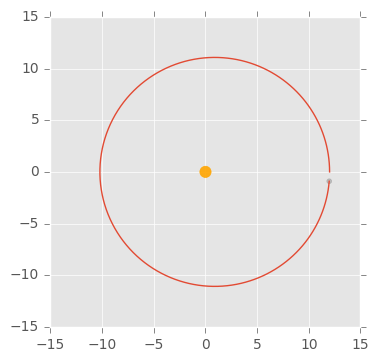

In [17]:
rx, ry = r.T
ax = plt.subplot(1,1,1)
ax.set_aspect(1)
ax.plot(rx, ry)
star_circle = plt.Circle([0, 0], star_radius_localunits, color='orange', alpha=0.9)
planet_circle = plt.Circle(r[-1], 5 * system_AU.iloc[idx]['radius']*1e3, color='gray', alpha=0.4)
ax.add_artist(star_circle);
ax.add_artist(planet_circle);

Looks ok.

In [18]:
planets

,name,mass,period,radius,semi-major,eccentricity
0,b,0.000032,1.510871,1.086,11.11,0.081
1,c,0.000052,2.421823,1.056,15.21,0.083
2,d,0.000015,4.049610,0.772,21.44,0.070
3,e,0.000023,6.099615,0.918,28.17,0.085
4,f,0.000025,9.206690,1.045,37.10,0.063
5,g,0.000050,12.352940,1.127,45.10,0.061


## Many body system 

### Star fixed
Assume that the central star (TRAPPIST1a) can be approximated as fixed.

In [19]:
def orbits(r0, v0, masses, M_star=M_star, dt=0.001, t_max=1):
    """2D planetary motion with velocity verlet for multiple planets"""
    N_bodies = len(masses)
    assert r0.shape[0] == N_bodies
    dim = r0.shape[1]
    assert np.all(v0.shape == r0.shape)

    nsteps = int(t_max/dt)

    r = np.zeros((nsteps, N_bodies, dim))
    v = np.zeros_like(r)

    r[0, :, :] = r0
    v[0, :, :] = v0

    # start force evaluation for first step
    Ft = forces(r[0], masses, M_star)
    for i in range(nsteps-1):
        vhalf = v[i] + 0.5*dt * Ft/masses[:, np.newaxis]
        r[i+1, :] = r[i] + dt * vhalf
        Ftdt = forces(r[i+1], masses, M_star)
        v[i+1] = vhalf + 0.5*dt * Ftdt/masses[:, np.newaxis]
        # new force becomes old force
        Ft = Ftdt
    return r, v

def forces(r, masses, M):
    F = np.zeros_like(r)
    for i, m in enumerate(masses):
        # planet - star (note: minus sign to be consistent with rij!)
        F[i, :] = F_gravity(-r[i], m=m, M=M)
        for j in range(i+1, len(masses)):
            # force of planet j on i
            rij = r[j] - r[i]
            Fij = F_gravity(rij, m=m, M=masses[j])
            F[i] += Fij
            # Newton's 3rd law:
            Fji = -Fij
            F[j] += Fji
    return F
            

In [20]:
r0 = np.array([planets_x, np.zeros_like(planets_x)]).T
v0 = np.array([np.zeros_like(planets_vy), planets_vy]).T
masses = planets['mass'].values

In [21]:
forces(r0, masses, M_star)

array([[-0.00523389,  0.        ],
       [-0.00451814,  0.        ],
       [-0.00069199,  0.        ],
       [-0.00058942,  0.        ],
       [-0.00038804,  0.        ],
       [-0.00051998, -0.        ]])

In [22]:
r, v = orbits(r0, v0, masses, t_max=5, dt=0.01)

In [23]:
r.shape

(500, 6, 2)

In [24]:
def plot_orbits(r):
    ax = plt.subplot(111)
    ax.set_aspect(1)
    for planet in range(r.shape[1]):
        rx, ry = r[:, planet, :].T
        ax.plot(rx, ry)
        ax.plot(rx[-1], ry[-1], 'o', ms=4, color="gray", alpha=0.5)
        planet_circle = plt.Circle([rx[-1], ry[-1]], 5 * system_AU.iloc[planet]['radius']*1e3, color='gray', alpha=0.4)
        ax.add_artist(planet_circle)
    ax.add_artist(plt.Circle([0, 0], star_radius_localunits, color='orange', alpha=0.9))
    return ax

Note that size *is to scale* (but planets are magnified 5 times).

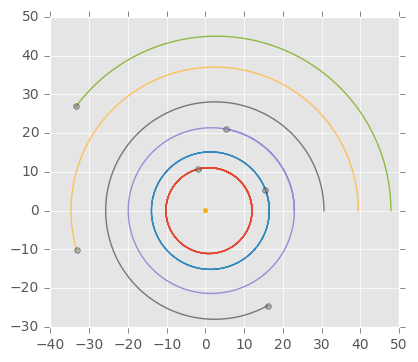

In [25]:
plot_orbits(r)

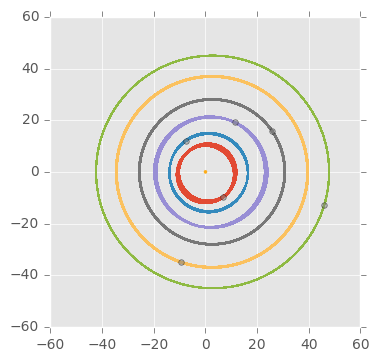

In [26]:
r, v = orbits(r0, v0, masses, t_max=1000, dt=0.01)
plot_orbits(r)

### BONUS: Star moves
Include movement of the central star (TRAPPIST1a). Choose initial conditions so that the total momentum of the system is zero.

In [27]:
def orbits2(r0, v0, masses, M_star=M_star, dt=0.001, t_max=1):
    """2D planetary motion with velocity verlet for multiple planets and star."""
    N_bodies = len(masses)
    assert r0.shape[0] == N_bodies
    dim = r0.shape[1]
    assert np.all(v0.shape == r0.shape)

    nsteps = int(t_max/dt)

    r = np.zeros((nsteps, N_bodies, dim))
    v = np.zeros_like(r)

    r[0, :, :] = r0
    v[0, :, :] = v0

    # start force evaluation for first step
    Ft = forces2(r[0], masses)
    for i in range(nsteps-1):
        vhalf = v[i] + 0.5*dt * Ft/masses[:, np.newaxis]
        r[i+1, :] = r[i] + dt * vhalf
        Ftdt = forces2(r[i+1], masses)
        v[i+1] = vhalf + 0.5*dt * Ftdt/masses[:, np.newaxis]
        # new force becomes old force
        Ft = Ftdt
        if np.linalg.norm(Ft.sum(axis=0)) > 1e-12:
            print("Violation of Newton's 3rd law: F = {}".format(Ft))
    return r, v

def forces2(r, masses):
    F = np.zeros_like(r)
    for i, m in enumerate(masses):
        for j in range(i+1, len(masses)):
            # force of body j on i
            rij = r[j] - r[i]
            Fij = F_gravity(rij, m=m, M=masses[j])
            F[i] += Fij
            # Newton's 3rd law:
            Fji = -Fij
            F[j] += Fji
    return F
            

In [28]:
# planets 
r0 = np.array([planets_x, np.zeros_like(planets_x)]).T
v0 = np.array([np.zeros_like(planets_vy), planets_vy]).T
masses = planets['mass'].values

# prepend star
r0_system = np.vstack((np.array([[0, 0]]), r0))

# choose star velocity to make total momentum 0
p_planets = np.sum(masses[:, np.newaxis] * v0, axis=0)
v0_star = -p_planets / M_star
v0_system = np.vstack((v0_star, v0))

masses_system = np.concatenate(([M_star], masses))

In [29]:
r0_system

array([[  0.     ,   0.     ],
       [ 12.00991,   0.     ],
       [ 16.47243,   0.     ],
       [ 22.9408 ,   0.     ],
       [ 30.56445,   0.     ],
       [ 39.4373 ,   0.     ],
       [ 47.8511 ,   0.     ]])

In [30]:
v0_system

array([[ -0.00000000e+00,  -6.01597122e-03],
       [  0.00000000e+00,   4.26152173e+01],
       [  0.00000000e+00,   3.63481792e+01],
       [  0.00000000e+00,   3.10180165e+01],
       [  0.00000000e+00,   2.66550243e+01],
       [  0.00000000e+00,   2.37461407e+01],
       [  0.00000000e+00,   2.15806073e+01]])

In [31]:
f0 = forces2(r0_system, masses_system)
print(f0)
f0.sum(axis=0)

[[ 0.01194524  0.        ]
 [-0.00523389  0.        ]
 [-0.0045201   0.        ]
 [-0.00069254  0.        ]
 [-0.00058976  0.        ]
 [-0.00038834  0.        ]
 [-0.00052062  0.        ]]


array([  1.40946282e-18,   0.00000000e+00])

In [32]:
r, v = orbits2(r0_system, v0_system, masses_system, t_max=5, dt=0.01)

In [33]:
r.shape

(500, 7, 2)

In [34]:
def plot_orbits2(r, ax=None, scale=5):
    if ax is None:
        ax = plt.subplot(111)
    ax.set_aspect(1)
    for planet in range(r.shape[1]):
        rx, ry = r[:, planet, :].T
        ax.plot(rx, ry)
        if planet == 0:
            # star
            ax.add_artist(plt.Circle([rx[-1], ry[-1]], star_radius_localunits, color='orange', alpha=0.9, zorder=1))
        else: # planet
            idx = planet - 1
            radius = scale * system_AU.iloc[idx]['radius']*1e3
            planet_circle = plt.Circle([rx[-1], ry[-1]], radius, color='gray', alpha=0.8, zorder=2)
            ax.add_artist(planet_circle)
    return ax

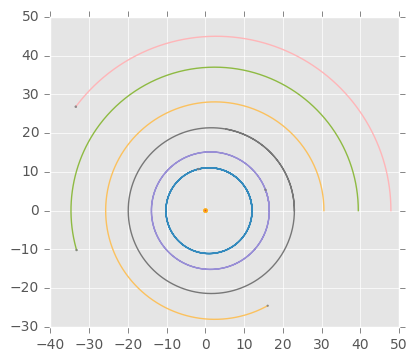

In [35]:
plot_orbits2(r)

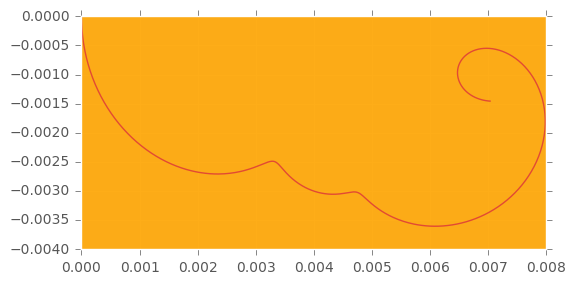

In [36]:
r_star = r[:, 0][:, np.newaxis, :]
plot_orbits2(r_star)
#star_size = plt.Circle(r_star[-1, 0], star_radius_localunits, color='gray', alpha=0.3)
#plt.gcf().gca().add_artist(star_size);

Now for 1000 d:

In [37]:
r, v = orbits2(r0_system, v0_system, masses_system, t_max=1000, dt=0.01)

(-50, 50)

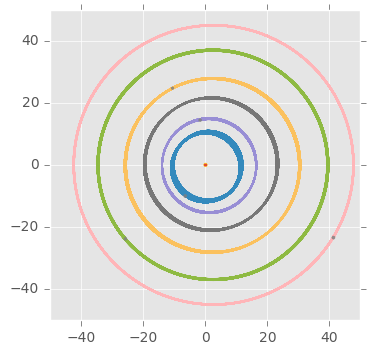

In [38]:
ax = plot_orbits2(r, scale=10)
ax.set_xlim(-50, 50)
ax.set_ylim(-50, 50)

(-0.6, 0.6)

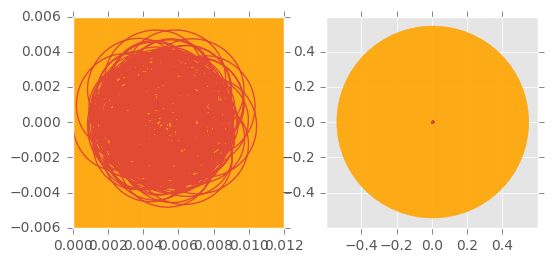

In [39]:
r_star = r[:, 0][:, np.newaxis, :]
ax1 = plt.subplot(121)
plot_orbits2(r_star, ax=ax1)
ax2 = plt.subplot(122)
plot_orbits2(r_star, ax=ax2)
ax2.set_xlim(-0.6, 0.6)
ax2.set_ylim(-0.6, 0.6)

In [40]:
star_radius_localunits

0.544182879201903

The orbit of the star TRAPPIST-1a is inside star. Thus the common center of mass of the system is inside the star itself and probably no clear wobble is observable.

Could the wobble be observed by [Doppler spectroscopy](https://en.wikipedia.org/wiki/Doppler_spectroscopy) measurements? Third generation instruments are sensitive to 0.1 m/s.

Assume ideal observation geometry (namely, observation side on). We approximate the [radial velocity](https://en.wikipedia.org/wiki/Radial_velocity) by the y-component of the velocity, $v_y$. (In principle it is the projection of the velocity on the observation direction but the change in angle is going to be very small and not much different from 0 because the observation distances is so much larger than the extend of the star motion. We could have also picked $v_x$ or any other viewing direction to get a sense for the magnitudes involved.)

Compute the time series of star velocities and look at the maximum differences.

In [41]:
v_star = v[:, 0]
vy_star = v_star[:, 1]  # in 1e-3 au/d
vy_star_ms = au2km(vy_star * 1e-3) * 1e3 / (24*3600)
dt = 0.01
time = dt * np.arange(0, len(vy_star))

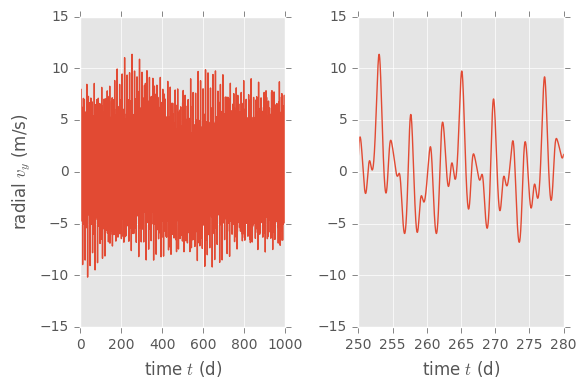

In [42]:
ax1 = plt.subplot(121)
ax1.plot(time, vy_star_ms)
ax1.set_xlabel(r"time $t$ (d)")
ax1.set_ylabel(r"radial $v_y$ (m/s)")
ax2 = plt.subplot(122)
ax2.plot(time, vy_star_ms)
ax2.set_xlabel(r"time $t$ (d)")
ax2.set_xlim(250, 280)
ax1.figure.tight_layout()

In [43]:
vy_max, vy_min = vy_star_ms.max(), vy_star_ms.min()
print("Delta v_radial = {0:.1f} m/s\nmax v_r = {1:.1f} m/s\nmin v_r = {2:.1f} m/s".format(vy_max-vy_min, vy_max, vy_min))

Delta v_radial = 21.8 m/s
max v_r = 11.4 m/s
min v_r = -10.4 m/s


Based on these radial velocity estimates, it should be easy to detect the planet motion with Doppler spectroscopy.

## Analysis of planet visibility 

Produce a time series of "number of visible planets from planet *i* as a function of time".

Or perhaps better: How many planets are close enough so that one could see (1) continents (1000 km) (2) cities (10 km)?


#### Resolution of the human eye
The [naked eye](https://en.wikipedia.org/wiki/Naked_eye) has a typical angular resolution of about $\theta_\text{eye} = 1'$ (**1 arcminute**), i.e., details that appear at a viewing angle of $\theta ≥ \theta_\text{eye}$ can be resolved.

The resolution of the eye in degrees:

In [44]:
theta_eye_minutes = 1.
print("{:.4f}º".format(theta_eye_minutes * 1/60))

0.0167º


The resolution of the eye in radians:

In [45]:
theta_eye = np.deg2rad(theta_eye_minutes * 1/60)
print(theta_eye)

0.000290888208666


In general, the viewing angle is the length of the arc $s$ through the end points of the object, divided by the distance $d$

$$
\theta = \frac{s}{d}
$$

but for $d \gg s$ (the usual situation in astronomy), we can make the small angle approximation and replace $s$ by the size $y$ of the object

$$
\theta \approx \frac{y}{d}.
$$

What is the  size $y$ as a function of distance $d$ that can be resolved with the naked eye?

$$
\theta ≥ \theta_\text{eye}
$$

and thus 

$$
y(d) ≥ \theta_\text{eye} d
$$

In [46]:
def y_resolved(d, theta=theta_eye):
    """Size of an object that can be resolved with the eye at distance d"""
    return theta_eye * d

In [47]:
d_values = np.linspace(1e3, 1e6, 20)

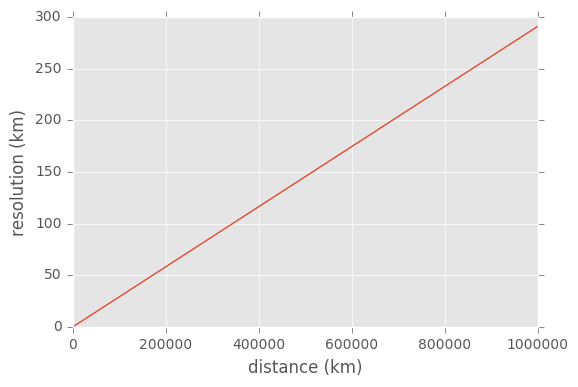

In [48]:
ax = plt.subplot(111)
ax.plot(d_values, y_resolved(d_values))
ax.set_xlabel("distance (km)")
ax.set_ylabel("resolution (km)")

### Best case scenario: What are the smallest features we can hope to resolve?
Find the closest distances between all planets (when they are at closest approach, i.e., *opposition* for planets farther out or *inferior conjunction* for planets towards the star as shown in [Viewing the planets](http://www.astro.cornell.edu/academics/courses/astro201/planet_view.htm), but note that the planet is not visible in inferior conjunction). (based on [How far is each planet from Earth?](http://curious.astro.cornell.edu/about-us/56-our-solar-system/planets-and-dwarf-planets/general-questions/214-how-far-is-each-planet-from-earth-intermediate))

In [49]:
system_AU

,name,mass,period,radius,semi-major,eccentricity
0,b,0.000003,0.004137,0.000046,0.01111,0.081
1,c,0.000004,0.006631,0.000045,0.01521,0.083
2,d,0.000001,0.011087,0.000033,0.02144,0.070
3,e,0.000002,0.016700,0.000039,0.02817,0.085
4,f,0.000002,0.025207,0.000045,0.03710,0.063
5,g,0.000004,0.033821,0.000048,0.04510,0.061
6,h,NaN,0.054758,0.000032,0.06300,NaN
7,star,0.080200,NaN,0.000544,NaN,NaN


In [50]:
a_km = au2km(system_AU['semi-major'])
print(a_km)

0    1.662032e+06
1    2.275384e+06
2    3.207378e+06
3    4.214172e+06
4    5.550081e+06
5    6.746864e+06
6    9.424666e+06
7             NaN
Name: semi-major, dtype: float64


What are the distances between *neighboring planets* when they are directly next to each other in their orbits (i.e., on one line between the star and the planets):

In [51]:
orbit_spacing = np.diff(a_km[:-1])
print(orbit_spacing)

[  613351.26987    931994.734461  1006793.669811  1335908.985351
  1196782.9656    2677801.88553 ]


In this case the range of resolved feature sizes (in km) is:

In [52]:
y_resolved(orbit_spacing)

array([ 178.41665218,  271.10627879,  292.86440711,  388.60017169,
        348.13005303,  778.94099364])

For the second neighbors:

In [53]:
y_resolved(a_km.values[2:-1] - a_km.values[:-3])

array([  449.52293097,   563.9706859 ,   681.4645788 ,   736.73022471,
        1127.07104667])

In general, compute *all* the distances for directly neighboring planets (e.g. *b* with *e*):

In [54]:
import scipy.spatial

In [55]:
resolved = y_resolved(scipy.spatial.distance.cdist(a_km[:-1, np.newaxis], a_km[:-1, np.newaxis]))
print(resolved)

[[    0.           178.41665218   449.52293097   742.38733808
   1130.98750977  1479.11756279  2258.05855643]
 [  178.41665218     0.           271.10627879   563.9706859    952.57085759
   1300.70091061  2079.64190426]
 [  449.52293097   271.10627879     0.           292.86440711   681.4645788
   1029.59463182  1808.53562547]
 [  742.38733808   563.9706859    292.86440711     0.           388.60017169
    736.73022471  1515.67121836]
 [ 1130.98750977   952.57085759   681.4645788    388.60017169     0.
    348.13005303  1127.07104667]
 [ 1479.11756279  1300.70091061  1029.59463182   736.73022471
    348.13005303     0.           778.94099364]
 [ 2258.05855643  2079.64190426  1808.53562547  1515.67121836
   1127.07104667   778.94099364     0.        ]]


The range of features that can be resolved when planets are directly next to each other in their orbits:

In [56]:
x = np.sort(np.triu(resolved, k=1).ravel())
np.round(x[x > 0]) #in km

array([  178.,   271.,   293.,   348.,   389.,   450.,   564.,   681.,
         737.,   742.,   779.,   953.,  1030.,  1127.,  1131.,  1301.,
        1479.,  1516.,  1809.,  2080.,  2258.])

### Sidenote: How big does the central star appear? 

Size of the star in arc minutes (angular diameter) when seen from the planet:

In [57]:
r_star_au = system_AU['radius'][system_AU['name'] == "star"].item()
a_au = system_AU['semi-major'][system_AU['name'] != "star"]
degrees = np.rad2deg(2*r_star_au/a_au)
delta_planets = pd.DataFrame(
    {"name": system_AU['name'][system_AU['name'] != "star"],
     "degrees": degrees // 1,
     "minutes": ((degrees % 1) * 60) // 1,
     "seconds": np.round((((degrees % 1) * 60) % 1) * 60),
     }, columns=("name", "degrees", "minutes", "seconds"))
delta_planets

,name,degrees,minutes,seconds
0,b,5.0,36.0,46.0
1,c,4.0,5.0,59.0
2,d,2.0,54.0,31.0
3,e,2.0,12.0,49.0
4,f,1.0,40.0,51.0
5,g,1.0,22.0,58.0
6,h,0.0,59.0,23.0


Check: [sun from earth: angular diameter](https://en.wikipedia.org/wiki/Angular_diameter#Use_in_astronomy): 31′31″ – 32′33″

In [58]:
r_sun = 695.8e3 # in km
d_earth_sun = au2km(1)
delta = np.rad2deg(2*r_sun/d_earth_sun)
delta_min_sec = (delta * 60) // 1, ((delta * 60) % 1) * 60
print("sun angular diameter {0[0]:.0f}'{0[1]:.0f}\"".format(delta_min_sec))

sun angular diameter 31'59"


Because the planets orbit so closely, their star is huge in their sky – between 2 to 15 times bigger than the sun in the earth's sky.

### Analysis of planet visibility
We keep the analysis simple and assume that we can observe other planets in essentially all positions, including all conjunctions (planets and star aligned).

We then only have to calculate the distances between planets as a function of time and apply our resolution criterion.

Analyze the trajectory for the planets (note: `r[:, 0]` is the star's trajectory):

In [59]:
r_planets = r[:, 1:]

Example for the zeroth time step (where all planets are in conjunction):

In [60]:
pos = r_planets[0]

We use `scipy.spatial.cdist()` for speed (otherwise calculate `rij` as in the integration code above).

In [61]:
dm = scipy.spatial.distance.cdist(pos, pos)
dm_km = au2km(dm * 1e-3)
print(dm)
print(dm_km)
y_resolved(dm_km)

[[  0.        4.46252  10.93089  18.55454  27.42739  35.84119]
 [  4.46252   0.        6.46837  14.09202  22.96487  31.37867]
 [ 10.93089   6.46837   0.        7.62365  16.4965   24.9103 ]
 [ 18.55454  14.09202   7.62365   0.        8.87285  17.28665]
 [ 27.42739  22.96487  16.4965    8.87285   0.        8.4138 ]
 [ 35.84119  31.37867  24.9103   17.28665   8.4138    0.     ]]
[[       0.           667583.48995616  1635237.86885592  2775719.67581798
   4103079.14285847  5361765.70735413]
 [  667583.48995616        0.           967654.37889976  2108136.18586181
   3435495.65290231  4694182.21739797]
 [ 1635237.86885592   967654.37889976        0.          1140481.80696205
   2467841.27400255  3726527.83849821]
 [ 2775719.67581798  2108136.18586181  1140481.80696205        0.
   1327359.46704049  2586046.03153615]
 [ 4103079.14285847  3435495.65290231  2467841.27400255  1327359.46704049
         0.          1258686.56449566]
 [ 5361765.70735413  4694182.21739797  3726527.83849821  2586046

array([[    0.        ,   194.19216553,   475.67141441,   807.42412426,
         1193.53734188,  1559.6744219 ],
       [  194.19216553,     0.        ,   281.47924889,   613.23195873,
          999.34517635,  1365.48225637],
       [  475.67141441,   281.47924889,     0.        ,   331.75270984,
          717.86592747,  1084.00300748],
       [  807.42412426,   613.23195873,   331.75270984,     0.        ,
          386.11321762,   752.25029764],
       [ 1193.53734188,   999.34517635,   717.86592747,   386.11321762,
            0.        ,   366.13708002],
       [ 1559.6744219 ,  1365.48225637,  1084.00300748,   752.25029764,
          366.13708002,     0.        ]])

Instead of finding all resolved distances, we will determine a cutoff distance and then just count how many planets are inside the cutoff distance.

$$
d(y) ≤ \frac{y}{\theta_\text{eye}}
$$



In [62]:
def dmin(y, theta=theta_eye):
    return y/theta

In [63]:
dmin(200)

687549.35415698786

In [104]:
np.sum(dm_km < dmin(500), axis=1)

array([3, 3, 4, 3, 3, 2])

#### Full analysis
Loop over all frames of the trajectory and calculate the number of visible planets for each planet.

In [105]:
def analyze_visible_planets(r_planets, ymin=500):
    cutoff = dmin(ymin)
    timeseries = np.zeros(r_planets.shape[:2])
    for i, pos in enumerate(r_planets):
        pos = pos * 1e-3  # in au
        dm = au2km(scipy.spatial.distance.cdist(pos, pos)) # in km
        timeseries[i, :] = np.sum(np.logical_and(dm > 1.0, dm < cutoff), axis=1)
    return timeseries

In [106]:
y_min = 1000 # km
counts = analyze_visible_planets(r_planets, ymin=y_min)

In [107]:
counts.shape

(100000, 6)

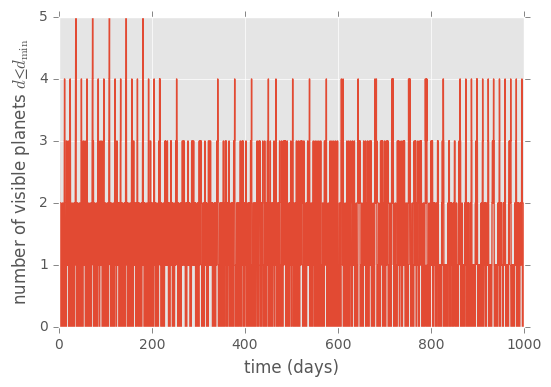

In [108]:
plt.plot(time, counts[:, 3])
plt.xlabel("time (days)")
plt.ylabel(r"number of visible planets $d ≤ d_\mathrm{min}$")

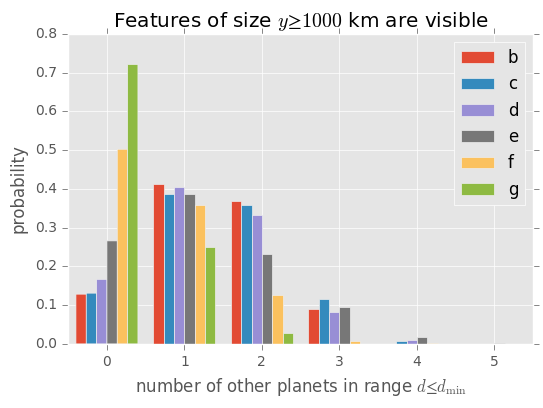

In [117]:
plt.hist(counts, bins=[-0.5, 0.5, 1.5, 2.5, 3.5, 4.5, 5.5], normed=True, label=planets['name'].tolist())
plt.legend(loc="best")
plt.xlabel("number of other planets in range $d ≤ d_\mathrm{min}$")
plt.ylabel("probability")
plt.title("Features of size $y ≥ {}$ km are visible".format(y_min))
plt.xlim(-0.5, 5.5);

In general, the inner planets (b, c, d) provide more opportunities to see other planets up close. However TRAPPIST-1e is the planet where it is most likely to see *four* other planets up close and it still has the second highest probability of any planet to have a close up view on *three* planets.

Thus, the poster advertising TRAPPIST-1e speaks the truth.